<a href="https://colab.research.google.com/github/RaghavendraGaleppa/EVA-Assignments/blob/master/Learning_tf_data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade tensorflow tensorflow-gpu

In [0]:
import tensorflow as tf
import numpy as np

# Converting numpy data to TFRecords

### First convert the numpy data in tf.data.Dataset Type

In [2]:
X_train, X_test = tf.keras.datasets.cifar10.load_data()
print(f"Shape of image data:{X_train[0].shape}, Shape of labels data:{X_train[1].shape}")

Shape of image data:(50000, 32, 32, 3), Shape of labels data:(50000, 1)


In [3]:
"""
Using tf.data.Dataset.from_tensor_slices is the method convert numpy arrays to tf.data.Dataset type
"""
import numpy as np

example = tf.data.Dataset.from_tensor_slices([0,1,43,123,31,45])
print(example)

example = tf.data.Dataset.from_tensor_slices(np.array([0,2,3,4,13,123,44,123,34]))
print(example)

example = tf.data.Dataset.from_tensor_slices(np.array([0.1,23.01]))
print(example)

<TensorSliceDataset shapes: (), types: tf.int32>
<TensorSliceDataset shapes: (), types: tf.int64>
<TensorSliceDataset shapes: (), types: tf.float64>


In [4]:
"""
    - You can loop over the tf.data.Dataset type as if it were an iterator.
    - Each Element of the tf.data.Dataset type is a tf.Tensor which is similar to numpy
    arrays but is a made for tensorflow and also supports GPU Operations.
    - Each of the tf.Tensor say for example some_tensor can be converted to numpy arrays by calling
    some_tensor.numpy() function
"""

# Here each 'e' is a tf.Tensor type 
# You can add, subtract, multiply, divide with tf.Tensor just like numpy arrays
# You can convert a tf.Tensor to a numpy array also

for e in example:
    print(e)
    print(e+1)
    print(e*10)
    print(e.numpy())

tf.Tensor(0.1, shape=(), dtype=float64)
tf.Tensor(1.1, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
0.1
tf.Tensor(23.01, shape=(), dtype=float64)
tf.Tensor(24.01, shape=(), dtype=float64)
tf.Tensor(230.10000000000002, shape=(), dtype=float64)
23.01


In [5]:
"""
    There is actually no straight-forward way of getting the length of a Dataset type,
    you have to find it in a brute force way
"""

example = tf.data.Dataset.from_tensor_slices(np.random.randn(100))

len_example = [i for i,_ in enumerate(example)][-1] + 1
print(f"Length of dataset is {len_example}")

Length of dataset is 100


In [6]:
"""
    - Now tf.data.Dataset is very similar to keras ImageDataGenerators but better and faster
    - Dataset has many functions which are made to be faster and efficient
"""

# Create a dataset with just zeros
dataset = tf.data.Dataset.from_tensor_slices([0,0,0,0,0])

# Using map function you can add a preprocessing function for the data
# You can also use lambda's instead of which can be converted to numpy as followsfunctions


def preprocessing_function(tensor):
    return tensor+1

dataset = dataset.map(preprocessing_function)
for element in dataset:
    print(element.numpy())

1
1
1
1
1


In [7]:
"""
    - from_tensor_slices function is made to take input a numpy array or python lists data 
    and return a dataset
    - You give both images and labels at the same time.
"""
images, labels = X_train[0], X_train[1]
dataset = tf.data.Dataset.from_tensor_slices((images, labels))


"""
    - element_spec is an attribute of dataset that holds a list of data's that we gave
    as input to from_tensor_slice and its properties.
"""
print("Different data's in the dataset are:")
print(f"The image data is: {dataset.element_spec[0]}")
print(f"The labesl is: {dataset.element_spec[1]}")

Different data's in the dataset are:
The image data is: TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)
The labesl is: TensorSpec(shape=(1,), dtype=tf.uint8, name=None)


### To convert our fresh dataset into TFRecords, first we have to convert it to a tf.train.Feature type
- a tf.train.Feature is one of these three: ByteList(string and byte type's), FloatList(float32 and float64) and IntList(All kinds of int types)
- while seeing the element_spec of our dataset in the above cell, we noticed that both images and labels are of tf.uint8 type so we need to convert our dataset into the int type tf.train.Feature.

### What is tf.train.Feature and why do we need it
- tf.train.Feature is a way to convert our python data types into something called protocol messages. 
- These protocol messages are of the form:
    ```python
    feature_type {
        value: value_of_the_data
    }
    ```
- For example
    ```python
    float32_list {
        value: 2.3461    
    }

    bytes_list {
        value: "Hello Bois"
    }

    int64_list {
        value: 24
    }
    ```

- More on Protocol Messages ahead.

### How to convert our dataset into int type tf.train.Feature?
- We need a wrapper function to do this
- You can use this [link](https://www.tensorflow.org/tutorials/load_data/tfrecord#tfexample) from tensorflow's documentation  to see the wrapper functions for byte, float and int type.
- We are gonna use the int type

In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [9]:
_bytes_feature(b'Hello Halalluaya')

bytes_list {
  value: "Hello Halalluaya"
}

In [10]:
_float_feature(22.32341)

float_list {
  value: 22.323410034179688
}

In [11]:
_int64_feature(1)

int64_list {
  value: 1
}

### How to convert numpy arrays into features
- You have to remember that tf.train.Feature can hold only 1-D array and since images have 3 dimensions(width, height, channels), you cannot directly plug it into given wrapper functions and expect them to work
- One method to do it is you can convert your numpy array into 1D array and then create tf.train.Feature object with it. However you have to again reshape the array back into its proper shape when extracting
- Another method is that you can directy convert your method directly into a string and then plug it in as a ByteList. I dont really how efficient this is, but this seems very hassle free and for smaller datasets, this might not show any problem whatsoever


In [12]:
example_array = np.random.randn(128,32,32,3).tostring()
print(example_array[:200])


b'~\xc7\xa8\xbb\xdb\xfd\x9d?\xd6\x0b\x9bW-\xab\xd4\xbfd\x00\x82\x14\xe1:\xe5?\x12\xd8\x8d2\xfb\xc0\xe3?F\x04\x85\xa3L\x9a\x9e\xbf\x99X\xb3\xff\x03/\xe6?\xbe\xb8\x1aPa>\x9d\xbfv\x0e-\n|\x12\xd0\xbf\xae#z\x18\x85a\xf3?\xf5\xb2\x968\xbc\x1b\xef\xbf9{|\xcdE\x8b\xc5\xbf\xc1Q\x1d,\xd4\xf4\x01\xc07Q\xe9\xeb\x7f\x1a\xf0\xbf\x93\n\x1f\x9a\x93\xd6\xf4?R\xfc/*\x0c7\xf1\xbf1;\x928\xe3j\xde\xbfJ\x92\x99\x87\xca[\xe0??&F\n\xeb\xbd\xd2\xbf\xac9{\xab\x92\xec\xe2\xbf*\x0bk#\xbe\xba\xd9\xbf\x89\x8c\x87\x848\xa5\xeb?\x91\x98\xf5]\xc9\x8e\xf2\xbf\x89\xc6\x01\x0c\xca\xd8\xe5?\xa3$-\x8fVl\xe0\xbf\xb2W&\xdb\xec\xba\xb6\xbf'


In [13]:
feature = _bytes_feature(example_array)
print(feature.SerializeToString()[:200])
#print(feature) wont work as it will exceed the limit of the notebook printing limit

b'\n\x85\x80\xc0\x01\n\x80\x80\xc0\x01~\xc7\xa8\xbb\xdb\xfd\x9d?\xd6\x0b\x9bW-\xab\xd4\xbfd\x00\x82\x14\xe1:\xe5?\x12\xd8\x8d2\xfb\xc0\xe3?F\x04\x85\xa3L\x9a\x9e\xbf\x99X\xb3\xff\x03/\xe6?\xbe\xb8\x1aPa>\x9d\xbfv\x0e-\n|\x12\xd0\xbf\xae#z\x18\x85a\xf3?\xf5\xb2\x968\xbc\x1b\xef\xbf9{|\xcdE\x8b\xc5\xbf\xc1Q\x1d,\xd4\xf4\x01\xc07Q\xe9\xeb\x7f\x1a\xf0\xbf\x93\n\x1f\x9a\x93\xd6\xf4?R\xfc/*\x0c7\xf1\xbf1;\x928\xe3j\xde\xbfJ\x92\x99\x87\xca[\xe0??&F\n\xeb\xbd\xd2\xbf\xac9{\xab\x92\xec\xe2\xbf*\x0bk#\xbe\xba\xd9\xbf\x89\x8c\x87\x848\xa5\xeb?\x91\x98\xf5]\xc9\x8e\xf2\xbf\x89\xc6\x01\x0c\xca\xd8\xe5?\xa3$-\x8fVl'


### Protocol Buffers
- Protocol Buffers are a mechanism to serialize data in a structure and efficient way
- Serialization of data is a way of converting the data types in python say numpy arrays, keras models, dictionaries, lists and other types into a byte format and the save them in a file so that you can load them later whenever you need them

- Protcol buffers are very efficient in the way they serialize data, and are faster than other mechanisms.

### tf.train.Example
- To use protocol buffers you need to specify protocol messages, these messages are converted into byte stream and then stored into files.
- tf.train.Example if a type of message is written as 
 {"string":value} mapping.

### Creating a tf.train.Example Message
- To create a tf.train.Example Message, you need to convert your tf.train.Feature in tf.train.Features.
- See below code to convert an image and its label into a tf.Example protocol message.


In [0]:
original_img = np.random.randn(32,32,3)
example = original_img.tostring()
img_feature = _bytes_feature(example)
# Say the label of the image is 5
label = _int64_feature(5)
feature_dict  = {
    'image':img_feature,
    'label':label
}
features = tf.train.Features(feature=feature_dict)
tf_example_message = tf.train.Example(features=features)

In [15]:
# This is our require byte format that will be written into tfrecord files
tf_example_message.SerializeToString()[:50]

b'\n\xa7\xc0\x01\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x05\n\x93\xc0\x01\n\x05image\x12\x88\xc0\x01\n\x84\xc0\x01\n\x80\xc0\x01\xc2g-\xeem\xb8\xea'

In [0]:
proto_bytes = tf_example_message.SerializeToString()

### Converting our serialized protocol message back into a numpy array
- You have to first define the structure of the original feature dictionary that you created before converting your tf.train.Feature into tf.train.Features.
- Create the dictionary with placeholder-like objects called tf.io.FixedLenFeature along with the data-type of each feature in the feature dict.
- Then take your protocol message and plug it into tf.io.parse_single_example with your placeholder-like feature dict

In [0]:

features = \
        {
            'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64)
        }

parse_out = tf.io.parse_single_example(features=features, serialized=proto_bytes)

In [0]:
img_out = np.frombuffer(parse_out['image'].numpy())
label_out = parse_out['label'].numpy()

In [19]:
print(f"{label_out}")

5


In [20]:
img_out == original_img.reshape(-1)

array([ True,  True,  True, ...,  True,  True,  True])

### Putting Everything in Place and writing data to tfrecord files
- Only thing left to do is to save stuff into tfrecord files and then read them back.
- The way to do this is through tf.io.TFRecordWriter
- We will now do eveything from scratch and save the CIFAR10 dataset into TFRecord files. 
- Also I am not sure if we should save the data for all the images in just a single file or not
- Make sure you have your shape of image in hand as numpy's tobytes() will flatten out the array


##### Writing to a TFRecord File

In [0]:
X_train, X_test = tf.keras.datasets.cifar10.load_data()

image_shape = X_train[0].shape

In [0]:
tf_record_file = 'cifar10.tfrecords'
with tf.io.TFRecordWriter(tf_record_file) as writer:
    for img, label in zip(X_train[0], X_train[1]):
        feature_dict = {
            'image': _bytes_feature(img.tobytes()),
            'label': _int64_feature(label)
        }
    
        features = tf.train.Features(feature=feature_dict)
        tf_example = tf.train.Example(features=features)
        protocol_message = tf_example.SerializeToString()

        writer.write(protocol_message)


In [24]:
# Yeah! As you can see that huge 150MB file is our entire train dataset for cifar10
!du -sh *

150M	cifar10.tfrecords
55M	sample_data


##### Reading from a tfrecord

In [0]:
feature_dict = {
    'image': tf.io.FixedLenFeature([],tf.string),
    'label': tf.io.FixedLenFeature([],tf.string)
}

dataset = tf.data.TFRecordDataset('cifar10.tfrecords')

In [0]:
serialized = None
for i in dataset.take(1): # take(4) will take the four items from the tfrecord
    serialized = i

In [0]:
"""parse_serialized
    - Now we also have to deocode the Image to its numpy form
    - To do this create placae-holders and then user the parse_from_single_example function
"""
feature_dict = {http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/a-guide/
    'image': tf.io.FixedLenFeature([],tf.string),
    'label': tf.io.FixedLenFeature([],tf.int64),
}
parsed_out = tf.io.parse_single_example(serialized=serialized, features=feature_dict)

tf.Tensor(6, shape=(), dtype=int64)


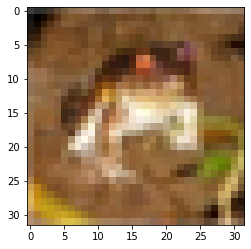

In [80]:
image = tf.io.decode_raw(parsed_out['image'],out_type=tf.uint8) # Decode the raw bytes
image = image.numpy() # Convert it to numpy
image = image.reshape(32,32,3) # Reshape the image back to its original size
plt.imshow(image) # Plot the image
print(parsed_out['label'])

In [0]:
"""
    - Lets write functions to do this automatically
"""
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def convert_np_to_tf_example(image, label):
    feature_dict = {
        'image': _bytes_feature(image.tostring()),
        'label': _int64_feature(label),
    }

    features = tf.train.Features(feature=feature_dict)
    tf_example = tf.train.Example(features=features)
    protocol_message = tf_example.SerializeToString()

    return protocol_message

def convert_proto_message_to_np(protocol_message):
    feature_dict = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_out = tf.io.parse_single_example(serialized=protocol_message,
                                            features=feature_dict)
    
    image = tf.io.decode_raw(parsed_out['image'], out_type=tf.uint8)
    label = parsed_out['label']

    return (image,label)
    
def reshape_img(X, img_shape):
    img = X[0].numpy()
    label = X[1]
    img = img.reshape(img_shape)
    img_tensor = tf.convert_to_tensor(img)

    return (img_tensor, label)
    

def convert_np_to_tfrecords(images, labels, 
                            batch_size=128,filename=None):
    """        for img in (images,labels):

        Converts a numpy array into TFReocrds
    """
    assert images.shape[0] == labels.shape[0], " Number of Images is not equal to number of labels"

    channels = images.shape[-1]
    width = images.shape[-2]
    height = images.shape[-3]

    img_shape = (height, width, channels)
    if filename == None:
        filename = 'dataset.tfrecords'
    with tf.io.TFRecordWriter(filename) as writer:
        for img,label in zip(images,labels):
            protocol_message = convert_np_to_tf_example(img,label)

            writer.write(protocol_message)
        
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(convert_proto_message_to_np)
    dataset = dataset.map(lambda x, y: (tf.reshape(x,img_shape), y))
    dataset = dataset.batch(batch_size)
    return dataset


tf.Tensor(6, shape=(), dtype=int64)


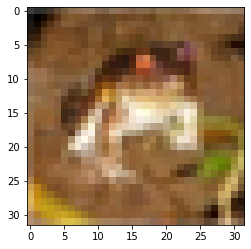

In [111]:
dataset = convert_np_to_tfrecords(X_train[0],X_train[1])
for d in dataset.take(1):
    plt.imshow(d[0].numpy()[0])
    print(d[1][0])

In [98]:
k(2,3)

(2, 3)